In [1]:
import arxiv
import pandas as pd
import nltk
import re
import torch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle

In [2]:
#Load Dataset of Physics papers
jsonfilename = 'arxiv-metadata-oai-snapshot.json'

categories_to_check = ['astro-ph','physics', 'gr-qc', 'hep', 'cond-mat']

# Initialize a list to store data
astro_ph_data = []

# Load the JSON file line by line
with open(jsonfilename, 'r') as file:
    for line in file:
        # Parse each line as JSON
        try:
            entry_data = json.loads(line)
        except json.JSONDecodeError:
            # Skip lines that cannot be parsed as JSON
            continue
        
        # Check if the paper belongs to the "astro-ph" category
        if 'categories' in entry_data and (any(cat in entry_data['categories'] for cat in categories_to_check)):
            # Extract the relevant information
            paper_info = {
                'id': entry_data.get('id', ''),
                'title': entry_data.get('title', ''),
                'authors': entry_data.get('authors'),
                'abstract': entry_data.get('abstract', ''),
                'category': entry_data.get('categories', ''),
                'link': f'https://arxiv.org/abs/{entry_data["id"]}'
                # Add more fields as needed
            }
            # Append the paper information to the list
            astro_ph_data.append(paper_info)

# Create a DataFrame from the collected data
df = pd.DataFrame(astro_ph_data)

FileNotFoundError: [Errno 2] No such file or directory: 'arxiv-metadata-oai-snapshot.json'

In [13]:
df.head()

,id,title,authors,abstract,category,link
0,0704.0001,Calculation of prompt diphoton production cros...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",A fully differential calculation in perturba...,hep-ph,https://arxiv.org/abs/0704.0001
1,0704.0003,The evolution of the Earth-Moon system based o...,Hongjun Pan,The evolution of Earth-Moon system is descri...,physics.gen-ph,https://arxiv.org/abs/0704.0003
2,0704.0006,Bosonic characters of atomic Cooper pairs acro...,Y. H. Pong and C. K. Law,We study the two-particle wave function of p...,cond-mat.mes-hall,https://arxiv.org/abs/0704.0006
3,0704.0007,Polymer Quantum Mechanics and its Continuum Limit,"Alejandro Corichi, Tatjana Vukasinac and Jose ...",A rather non-standard quantum representation...,gr-qc,https://arxiv.org/abs/0704.0007
4,0704.0008,Numerical solution of shock and ramp compressi...,Damian C. Swift,A general formulation was developed to repre...,cond-mat.mtrl-sci,https://arxiv.org/abs/0704.0008


In [14]:
# Preprocessing function
def preprocess_abstract(abstract):
    # Convert to lowercase
    abstract = abstract.lower()
    # Remove special characters
    abstract = re.sub(r'[^\w\s]', '', abstract)
    # abstract = re.sub(r'[^\w\s]|[$\n]', '', abstract)
    # abstract = re.sub(r'[^\w]|[$\n]', '', abstract)
    return abstract

In [15]:
df['cleaned_title'] = df['title'].apply(preprocess_abstract)

In [16]:
df['cleaned_authors'] = df['authors'].apply(preprocess_abstract)

In [17]:
df['cleaned_abstract'] = df['abstract'].apply(preprocess_abstract)

In [18]:
# df['cleaned_data'] = df['cleaned_title'] + ' ' +  df['cleaned_authors'] + ' ' + df['cleaned_abstract']
df['cleaned_data'] = df['cleaned_title'] + ' ' + df['cleaned_abstract']

In [19]:
df.head()

,id,title,authors,abstract,category,link,cleaned_title,cleaned_authors,cleaned_abstract,cleaned_data
0,0704.0001,Calculation of prompt diphoton production cros...,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",A fully differential calculation in perturba...,hep-ph,https://arxiv.org/abs/0704.0001,calculation of prompt diphoton production cros...,c balazs e l berger p m nadolsky cp yuan,a fully differential calculation in perturba...,calculation of prompt diphoton production cros...
1,0704.0003,The evolution of the Earth-Moon system based o...,Hongjun Pan,The evolution of Earth-Moon system is descri...,physics.gen-ph,https://arxiv.org/abs/0704.0003,the evolution of the earthmoon system based on...,hongjun pan,the evolution of earthmoon system is describ...,the evolution of the earthmoon system based on...
2,0704.0006,Bosonic characters of atomic Cooper pairs acro...,Y. H. Pong and C. K. Law,We study the two-particle wave function of p...,cond-mat.mes-hall,https://arxiv.org/abs/0704.0006,bosonic characters of atomic cooper pairs acro...,y h pong and c k law,we study the twoparticle wave function of pa...,bosonic characters of atomic cooper pairs acro...
3,0704.0007,Polymer Quantum Mechanics and its Continuum Limit,"Alejandro Corichi, Tatjana Vukasinac and Jose ...",A rather non-standard quantum representation...,gr-qc,https://arxiv.org/abs/0704.0007,polymer quantum mechanics and its continuum limit,alejandro corichi tatjana vukasinac and jose a...,a rather nonstandard quantum representation ...,polymer quantum mechanics and its continuum li...
4,0704.0008,Numerical solution of shock and ramp compressi...,Damian C. Swift,A general formulation was developed to repre...,cond-mat.mtrl-sci,https://arxiv.org/abs/0704.0008,numerical solution of shock and ramp compressi...,damian c swift,a general formulation was developed to repre...,numerical solution of shock and ramp compressi...


In [21]:
cleaned_data = [data for data in df['cleaned_data']]

### Sentence Transformers Encoding

In [22]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

/Users/raghav/opt/anaconda3/envs/arXivClustering/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/Users/raghav/opt/anaconda3/envs/arXivClustering/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


#### Load embeddings 

In [ ]:
file = open('embeddings_pca.pkl', "rb")
embeddings_pca = pickle.load(file)
file.close()

#### Generate embeddings (optional) 

In [ ]:
#Set torch device
if torch.backends.mps.is_available():
    device_str = "mps"  
elif torch.cuda.is_available():
    device_str = "cuda"
else:
    device_str = "cpu"
print(device_str)

In [ ]:
#Generate embeddings (optional)
embeddings = model.encode(cleaned_data, show_progress_bar=True,device=device_str)

#### PCA on Embeddings

In [ ]:
#PCA 
pca = PCA(n_components=0.95, random_state = 42)
embeddings_pca = pca.fit_transform(embeddings)

In [ ]:
#Save embeddings (optional)
pickle.dump(embeddings_pca, open('embeddings_pca.pkl', 'wb'))

In [ ]:
#K Means Clustering
k = 20
k_means = KMeans(n_clusters=k, random_state=42)
clusters = k_means.fit_predict(embeddings_pca)

In [ ]:
df['final_cluster'] = clusters

In [ ]:
#Save dataset
pickle.dump(df,open('cleaned_dataset.pkl', 'wb'))

In [ ]:
#Save Model
cluster_model = {'kmeans':k_means,'encoder':model, 'pca':pca}

pickle.dump(cluster_model,open('clustering_encoder_model.pkl', 'wb'))

### TfidfVectorizer Encoding Approach (Optional)

In [20]:
# Define the maximum number of features
max_features = 2**8
# max_features = 2**9
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=max_features)

In [207]:
X_cleaned = vectorizer.fit_transform(cleaned_data).toarray()

In [208]:
X_cleaned.shape

(1218455, 256)

### Number of Clusters Analysis

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np

# run kmeans with many different k
distortions = []
K = range(2, 50)
for k in K:
    print(f'Num clusters = {k}')
    k_means = KMeans(n_clusters=k, random_state=42)
    k_means.fit(X_cleaned_pca)
    distortions.append(sum(np.min(cdist(X_cleaned_pca, k_means.cluster_centers_, 'euclidean'), axis=1)) / X_cleaned.shape[0])
    #print('Found distortion for {} clusters'.format(k))


Num clusters = 2
Num clusters = 3
Num clusters = 4
Num clusters = 5
Num clusters = 6
Num clusters = 7
Num clusters = 8
Num clusters = 9
Num clusters = 10
Num clusters = 11
Num clusters = 12
Num clusters = 13
Num clusters = 14
Num clusters = 15
Num clusters = 16
Num clusters = 17
Num clusters = 18
Num clusters = 19
Num clusters = 20
Num clusters = 21
Num clusters = 22
Num clusters = 23
Num clusters = 24
Num clusters = 25
Num clusters = 26
Num clusters = 27
Num clusters = 28
Num clusters = 29
Num clusters = 30
Num clusters = 31
Num clusters = 32
Num clusters = 33
Num clusters = 34
Num clusters = 35
Num clusters = 36
Num clusters = 37
Num clusters = 38
Num clusters = 39
Num clusters = 40
Num clusters = 41
Num clusters = 42
Num clusters = 43
Num clusters = 44
Num clusters = 45
Num clusters = 46
Num clusters = 47
Num clusters = 48
Num clusters = 49


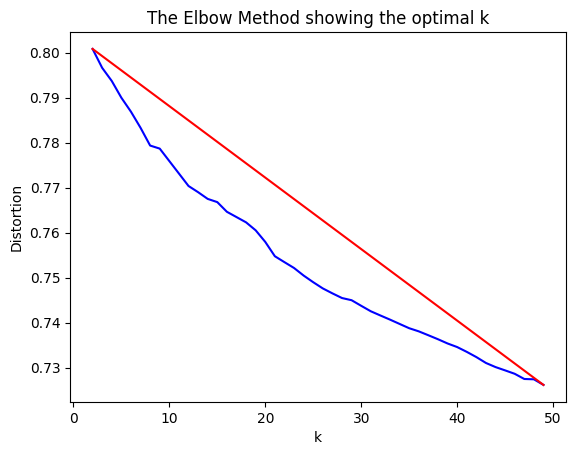

In [57]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
#K Means Clustering
k = 20
k_means = KMeans(n_clusters=k, random_state=42)
clusters = k_means.fit_predict(X_cleaned)

In [19]:
df['final_cluster'] = clusters

### Testing  

In [65]:
test_title = 'Observation of Gravitational Waves from a Binary Black Hole Merger'
test_abstract = "On September 14, 2015 at 09:50:45 UTC the two detectors of the Laser Interferometer Gravitational-Wave Observatory simultaneously observed a transient gravitational-wave signal. The signal sweeps upwards in frequency from 35 to 250 Hz with a peak gravitational-wave strain of 1.0×10−21. It matches the waveform predicted by general relativity for the inspiral and merger of a pair of black holes and the ringdown of the resulting single black hole. The signal was observed with a matched-filter signal-to-noise ratio of 24 and a false alarm rate estimated to be less than 1 event per 203 000 years, equivalent to a significance greater than 5.1 {\sigma}. The source lies at a luminosity distance of 410+160−180 Mpc corresponding to a redshift z=0.09+0.03−0.04. In the source frame, the initial black hole masses are 36+5−4M⊙ and 29+4−4M⊙, and the final black hole mass is 62+4−4M⊙, with 3.0+0.5−0.5M⊙c2 radiated in gravitational waves. All uncertainties define 90% credible intervals.These observations demonstrate the existence of binary stellar-mass black hole systems. This is the first direct detection of gravitational waves and the first observation of a binary black hole merger."

preprocessed_test_abstract = preprocess_abstract(test_abstract)
preprocessed_test_title = preprocess_abstract(test_title)

preprocessed_test_text = preprocessed_test_title + " " + preprocessed_test_abstract 

In [66]:
preprocessed_test_text

'observation of gravitational waves from a binary black hole merger on september 14 2015 at 095045 utc the two detectors of the laser interferometer gravitationalwave observatory simultaneously observed a transient gravitationalwave signal the signal sweeps upwards in frequency from 35 to 250 hz with a peak gravitationalwave strain of 101021 it matches the waveform predicted by general relativity for the inspiral and merger of a pair of black holes and the ringdown of the resulting single black hole the signal was observed with a matchedfilter signaltonoise ratio of 24 and a false alarm rate estimated to be less than 1 event per 203 000 years equivalent to a significance greater than 51 sigma the source lies at a luminosity distance of 410160180 mpc corresponding to a redshift z009003004 in the source frame the initial black hole masses are 3654m and 2944m and the final black hole mass is 6244m with 300505mc2 radiated in gravitational waves all uncertainties define 90 credible interval

In [67]:
test_embeddings = model.encode(preprocessed_test_text, show_progress_bar=True).reshape(1,-1)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [68]:
test_embeddings_pca = pca.transform(test_embeddings)

In [256]:
#Run only if using Tfidf
test_text_encode = vectorizer.transform([preprocessed_test_text]).toarray()
pred = k_means.predict(test_text_encode)

In [70]:
pred = k_means.predict(test_embeddings_pca)

In [72]:
results = df[df['final_cluster'] == pred.item()]

In [73]:
results.head()

,id,title,authors,abstract,category,link,cleaned_title,cleaned_authors,cleaned_abstract,cleaned_data,final_cluster
80,0704.0138,Circular and non-circular nearly horizon-skimm...,"Enrico Barausse, Scott A. Hughes, Luciano Rezz...",We have performed a detailed analysis of orb...,gr-qc astro-ph,https://arxiv.org/abs/0704.0138,circular and noncircular nearly horizonskimmin...,enrico barausse scott a hughes luciano rezzolla,we have performed a detailed analysis of orb...,circular and noncircular nearly horizonskimmin...,4
137,0704.0207,Quark matter and the astrophysics of neutron s...,M Prakash,Some of the means through which the possible...,astro-ph gr-qc nucl-th,https://arxiv.org/abs/0704.0207,quark matter and the astrophysics of neutron s...,m prakash,some of the means through which the possible...,quark matter and the astrophysics of neutron s...,4
145,0704.0223,Magnetohydrodynamic Rebound Shocks of Supernovae,"Yu-Qing Lou (1,2,3) and Wei-Gang Wang (1), ((1...",We construct magnetohydrodynamic (MHD) simil...,astro-ph,https://arxiv.org/abs/0704.0223,magnetohydrodynamic rebound shocks of supernovae,yuqing lou 123 and weigang wang 1 1 tsinghua c...,we construct magnetohydrodynamic mhd similar...,magnetohydrodynamic rebound shocks of supernov...,4
242,0704.0356,AMR simulations of the low T/|W| bar-mode inst...,"Pablo Cerd\'a-Dur\'an, Vicent Quilis, Jos\'e A...",It has been recently argued through numerica...,astro-ph,https://arxiv.org/abs/0704.0356,amr simulations of the low tw barmode instabil...,pablo cerdaduran vicent quilis jose a font,it has been recently argued through numerica...,amr simulations of the low tw barmode instabil...,4
256,0704.0374,Gravity-induced electric polarization of matte...,"Boris A. Zon, Igor Yu. Kretinin",This paper has been withdrawn due to copyrig...,physics.geo-ph,https://arxiv.org/abs/0704.0374,gravityinduced electric polarization of matter...,boris a zon igor yu kretinin,this paper has been withdrawn due to copyrig...,gravityinduced electric polarization of matter...,4


In [74]:
results_cleaned_data = results['cleaned_data'].tolist()
results_X = model.encode(results_cleaned_data,show_progress_bar=True)

#For Tfidf
# results_X = vectorizer.transform(results_cleaned_data)


Batches:   0%|          | 0/949 [00:00<?, ?it/s]

In [75]:
results_X_pca = pca.transform(results_X)

In [76]:
# similarities = cosine_similarity(test_text_encode, X_cleaned).flatten()
similarities = cosine_similarity(test_embeddings_pca, embeddings_pca).flatten()

# Get the indices of the top 10 most similar papers
top_indices = similarities.argsort()[-20:][::-1]

# Display the titles and abstracts of the top 10 most similar papers
print(f"Given Paper: {test_title}\n")
print(f"Abstract: {test_abstract}\n")
print(f'Predicted Cluster: {pred.item()}\n')

print("Top 10 similar papers:")
for idx in top_indices:
    print(f"Title: {df.iloc[idx]['title']}\n")
    print(f"Abstract: {df.iloc[idx]['abstract']}\n")
    print(f"Assigned Cluster: {df.iloc[idx]['final_cluster']}\n")
    print(f"Similarity: {similarities[idx]}")
    print("\n")

Given Paper: Observation of Gravitational Waves from a Binary Black Hole Merger

Abstract: On September 14, 2015 at 09:50:45 UTC the two detectors of the Laser Interferometer Gravitational-Wave Observatory simultaneously observed a transient gravitational-wave signal. The signal sweeps upwards in frequency from 35 to 250 Hz with a peak gravitational-wave strain of 1.0×10−21. It matches the waveform predicted by general relativity for the inspiral and merger of a pair of black holes and the ringdown of the resulting single black hole. The signal was observed with a matched-filter signal-to-noise ratio of 24 and a false alarm rate estimated to be less than 1 event per 203 000 years, equivalent to a significance greater than 5.1 {\sigma}. The source lies at a luminosity distance of 410+160−180 Mpc corresponding to a redshift z=0.09+0.03−0.04. In the source frame, the initial black hole masses are 36+5−4M⊙ and 29+4−4M⊙, and the final black hole mass is 62+4−4M⊙, with 3.0+0.5−0.5M⊙c2 radiat

In [264]:
#Save Model and data Tfidf
model = {'dataframe':df, 'embeddings':X_cleaned, 'kmeans':k_means, 'vectorizer':vectorizer}